In [1]:
import os
import pandas as pd
import numpy as np
import torch
import seaborn as sns
from scipy.stats import spearmanr, pearsonr
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score

In [2]:
test_results_path ='./data/SWOW_prediction/eval/'

In [3]:
properties = ['previous_link','polarity']
model_name = 'bert-base-uncased'
reduces = ['forward','both']
data_name = 'nyt'
train_sections = np.arange(0, 5)
loss_function_name = 'likelihood_loss'
graph_strategy = 'ppmi'
token_strategy ='frequency'
graph_version = 2
swow_version = 1
fill = 'add'
add_self_loops = True
sections = ['dev','test']
baselines = [True, False]

In [4]:

list_rows = []

for property in properties:
    
    for baseline in baselines:
        
        for reduce in reduces:
            for section in sections:
                total_df = pd.DataFrame()
                
                for train_section in train_sections:
                    
                
                    
                    if baseline == True:
                        df_dir = test_results_path + f'{property}_basic_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv'
                    else:
                        df_dir = test_results_path + f'{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv'
                   
                    if not os.path.exists(df_dir):
                        continue

                    
                    df = pd.read_csv(df_dir)
                    total_df = pd.concat((total_df,df),ignore_index = True)
                if len(total_df) ==0:
                    continue
                # print(len(total_df), property, baseline, reduce, train_section)
                df = total_df.groupby(['words'])[['targets','outputs']].mean().reset_index()
                
                r, p =pearsonr(df.targets, df.outputs)
                n = len(df)
                r2 = r2_score(df.targets, df.outputs)
                m =None
                if baseline == True:
                    m = 'BERT'
                elif reduce == 'both':
                    
                    m = 'GCN + BERT'
                
                elif reduce == 'forward':
                    m ='GCN'
                

                row = {'model':m, 
                       'r':float(r),
                       'p':p, 
                       'r2':r2,
                       'train_section' : train_section,
                      'test_section':section,
                      'property': property, 'n':n}
                list_rows.append(row)

results = pd.DataFrame(list_rows)
print(results.loc[results.test_section == 'test'].groupby(['model','property'])[['r','r2','n','p']].mean().reset_index().\
sort_values(by = ['property','r','r2','n','p']))

        model       property         r        r2      n              p
2         GCN       polarity  0.620209  0.382576  789.0   4.759296e-85
0        BERT       polarity  0.624784  0.306261  789.0   1.216242e-86
4  GCN + BERT       polarity  0.665063  0.438887  789.0  6.859994e-102
3         GCN  previous_link  0.623463  0.385129  883.0   2.997597e-96
1        BERT  previous_link  0.631798  0.397537  883.0   1.474450e-99
5  GCN + BERT  previous_link  0.644747  0.414203  883.0  6.652553e-105


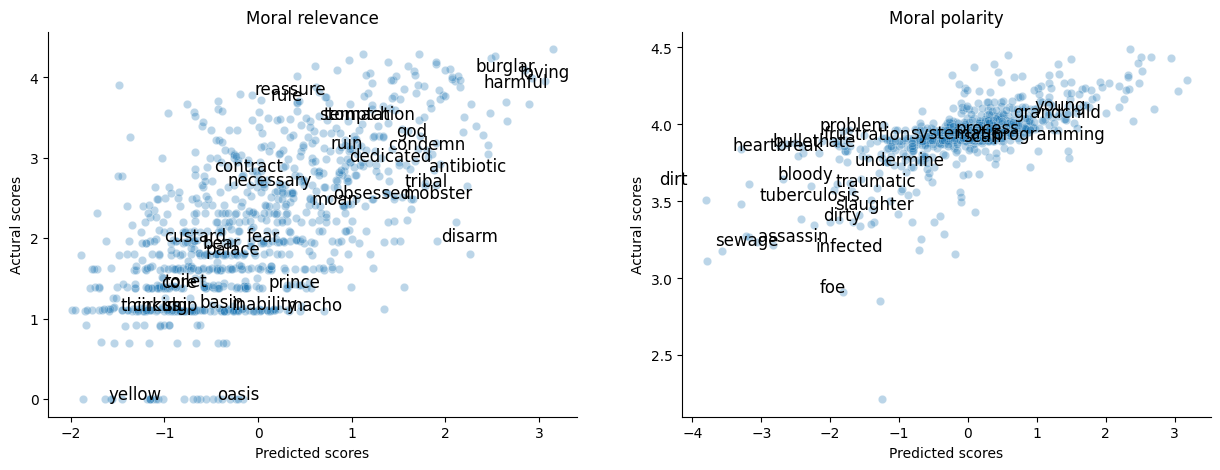

In [5]:
fig, axes = plt.subplots(1, 2, figsize = (15, 5))
total_df = pd.DataFrame()
for train_section in range(0, 5):
    section = 'test'
    reduce = 'both'
    property = 'previous_link'
    df_dir = test_results_path + f'{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv'             
    df = pd.read_csv(df_dir)
    df['section'] =[train_section] * len(df)
    mean_val = df['outputs'].mean()
    std_val = df['outputs'].std()
    df['z_score'] = df['outputs'].apply(lambda x : (x-mean_val) / std_val)
    total_df = pd.concat((total_df, df), ignore_index = True)
total_df =total_df.groupby(['words']).mean().reset_index()   
r, p = pearsonr(total_df.targets, total_df.z_score)
n = len(total_df)
ax = axes[0]
sns.scatterplot(data = total_df, y = 'targets', x = 'z_score',alpha = 0.3, ax = ax)
for i, row in df.iterrows():
    random_choice = np.random.rand()
    if random_choice >= .975:
        ax.text(y = row['targets'], x = row['z_score'], s= row['words'],size = 12)
ax.set_title('Moral relevance')
ax.set_xlabel('Predicted scores')
ax.set_ylabel('Actural scores')
total_df = pd.DataFrame()
for train_section in range(0, 5):
    section = 'test'
    reduce = 'both'
    property = 'polarity'
    df_dir = test_results_path + f'{property}_{model_name}_{reduce}_{data_name}_{train_section}_{loss_function_name}_graph_{graph_strategy}_graph_version_{graph_version}_swow_version_{swow_version}_fill_{fill}_add_self_loops_{add_self_loops}_token_strategy_{token_strategy}_{section}.csv'             
    df = pd.read_csv(df_dir)
    df['section'] =[train_section] * len(df)
    mean_val = df['outputs'].mean()
    std_val = df['outputs'].std()
    df['z_score'] = df['outputs'].apply(lambda x : (x-mean_val) / std_val)
    total_df = pd.concat((total_df, df), ignore_index = True)
total_df =total_df.groupby(['words']).mean().reset_index()   
r, p = pearsonr(total_df.targets, total_df.z_score)
n = len(total_df)
ax = axes[1]
sns.scatterplot(data = total_df, y = 'targets', x = 'z_score',alpha = 0.3, ax = ax)
for i, row in df.iterrows():
    random_choice = np.random.rand()
    
    if random_choice >= .99:
        plt.text(y = row['targets'], x = row['z_score'], s= row['words'],size = 12)
    if row['z_score'] < -1.5:
        random_choice = np.random.rand()
        if random_choice >= .8:
            plt.text(y = row['targets'], x = row['z_score'], s= row['words'],size = 12)
            
ax.set_title('Moral polarity')
ax.set_xlabel('Predicted scores')
ax.set_ylabel('Actural scores')

sns.despine()
plt.show()